In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift, fftn, ifftn
import glob
import cv2
from scipy.ndimage import uniform_filter

import ipywidgets as widgets
import os
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib.colors import hsv_to_rgb
from matplotlib.colors import Normalize
from scipy.ndimage import uniform_filter
from scipy.stats import binned_statistic_2d


%matplotlib inline

In [2]:
ret_path = '3d_dataset/retardance3D/*'
azimuth_path = '3d_dataset/azimuth/*'
theta_path = '3d_dataset/theta/*'

ret_files = sorted(glob.glob(ret_path))
azimuth_files = sorted(glob.glob(azimuth_path))
theta_files = sorted(glob.glob(theta_path))

In [3]:
N_z = 96
ps = 6.9/63
psz = 0.25
wavelength = 0.532

ret = []
azimuth = []
theta = []
for i in range(N_z):
    ret.append(cv2.imread(ret_files[i], -1).astype('float32'))
    azimuth.append(cv2.imread(azimuth_files[i], -1).astype('float32'))
    theta.append(cv2.imread(theta_files[i], -1).astype('float32'))

In [4]:
ret = np.transpose(np.array(ret),(1,2,0))/10000
azimuth = np.transpose(np.array(azimuth),(1,2,0))/18000*np.pi
theta = np.transpose(np.array(theta),(1,2,0))/18000*np.pi

In [5]:
def plot3DVectorField(img, azimuth, theta, threshold=None,anisotropy=1, cmapImage='gray', 
                      clim=[None, None], aspect=1, spacing=20, window=20, linelength=20, 
                      linewidth=3, linecolor='g', cmapAzimuth='hsv', alpha=1, subplot_ax = None):
    
    U = anisotropy*linelength*np.cos(2*azimuth)
    V = anisotropy*linelength*np.sin(2*azimuth)
    
    USmooth = uniform_filter(U, (window, window)) # plot smoothed vector field
    VSmooth = uniform_filter(V, (window, window)) # plot smoothed vector field
    azimuthSmooth = 0.5*np.arctan2(VSmooth,USmooth)
    RSmooth = np.sqrt(USmooth**2+VSmooth**2)
    USmooth, VSmooth = RSmooth*np.cos(azimuthSmooth), RSmooth*np.sin(azimuthSmooth)
    
    nY, nX = img.shape
    Y, X = np.mgrid[0:nY,0:nX] # notice the reversed order of X and Y
    
    # Plot sparsely sampled vector lines
    Plotting_X = X[::-spacing, ::spacing]
    Plotting_Y = Y[::-spacing, ::spacing]
    Plotting_U = linelength * USmooth[::-spacing, ::spacing]
    Plotting_V = linelength * VSmooth[::-spacing, ::spacing]
    
    Plotting_inc = ((theta[::-spacing, ::spacing])%np.pi)*180/np.pi
    
    if threshold is None:
        threshold = np.ones_like(X) # no threshold
        
    Plotting_thres = threshold[::-spacing, ::spacing]
    
    if subplot_ax is None:
        im_ax = plt.imshow(img, cmap=cmapImage, vmin=clim[0], vmax=clim[1], origin='lower', aspect=aspect)
        plt.title('3D Orientation map')
        plt.quiver(Plotting_X[Plotting_thres==1], Plotting_Y[Plotting_thres==1], 
                   Plotting_U[Plotting_thres==1], Plotting_V[Plotting_thres==1], 
                   Plotting_inc[Plotting_thres==1],
                   cmap=cmapAzimuth, norm = Normalize(vmin=0, vmax=180),
                   edgecolor=linecolor, facecolor=linecolor,units='xy', alpha=alpha, width=linewidth,
                   headwidth = 0, headlength = 0, headaxislength = 0,
                   scale_units = 'xy',scale = 1, angles = 'uv', pivot = 'mid')
    else:
        im_ax = subplot_ax.imshow(img, cmap=cmapImage, vmin=clim[0], vmax=clim[1], origin='lower', aspect=aspect)
        subplot_ax.set_title('3D Orientation map')
        subplot_ax.quiver(Plotting_X[Plotting_thres==1], Plotting_Y[Plotting_thres==1],
                          Plotting_U[Plotting_thres==1], Plotting_V[Plotting_thres==1], 
                          Plotting_inc[Plotting_thres==1],
                          cmap=cmapAzimuth, norm = Normalize(vmin=0, vmax=180),
                          edgecolor=linecolor, facecolor=linecolor,units='xy', alpha=alpha,
                          width=linewidth,
                          headwidth = 0, headlength = 0, headaxislength = 0,
                          scale_units = 'xy',scale = 1, angles = 'uv', pivot = 'mid')

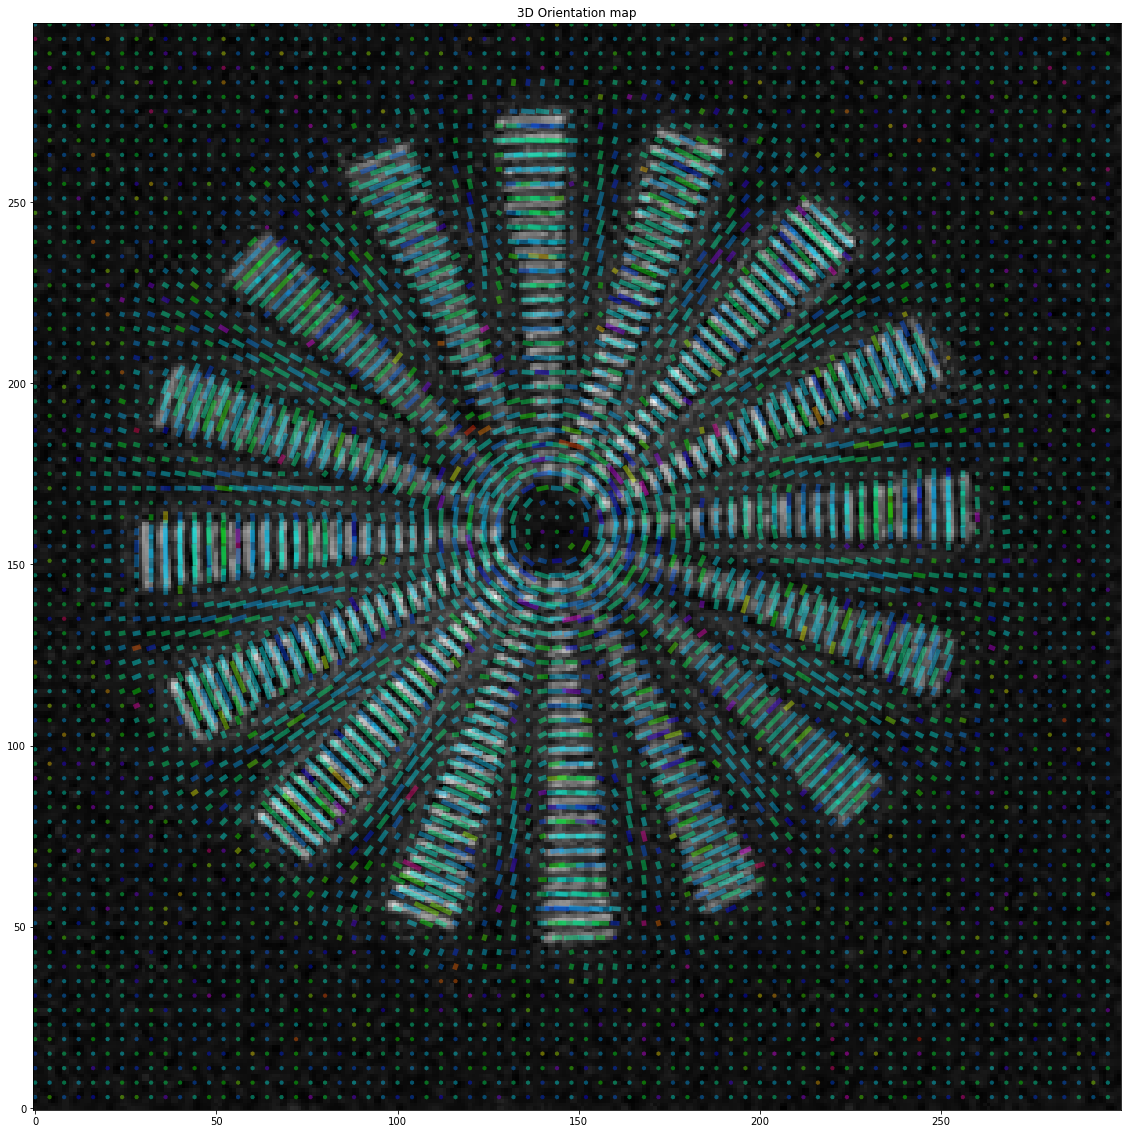

In [6]:
z_layer =44
ret_min = 0
ret_max = 4
spacing = 4

plt.figure(figsize=(20,20))
plot3DVectorField(np.abs(ret[:,:,z_layer]), azimuth[:,:,z_layer], theta[:,:,z_layer], 
                     anisotropy=0.2*np.abs(ret[:,:,z_layer]), cmapImage='gray', clim=[ret_min, ret_max], aspect=1, 
                     spacing=spacing, window=4*spacing, linelength=spacing*1.8, linewidth=1.3, cmapAzimuth='hsv', alpha=0.4)


In [7]:
def orientation_3D_to_rgb(hsv, interp_belt = 20/180*np.pi, sat_factor = 1):
    """
    Convert hsv values to rgb.
    Parameters
    ----------
    hsv : (..., 3) array-like
       [h, s, v] is refered to [hue, saturation(inclination), value]
       h and v are assumed to be in range [0, 1]
       s is assumed to be in range of [0, pi]
    Returns
    -------
    rgb : (..., 3) ndarray
       Colors converted to RGB values in range [0, 1]
    """
    hsv = np.asarray(hsv)

    # check length of the last dimension, should be _some_ sort of rgb
    if hsv.shape[-1] != 3:
        raise ValueError("Last dimension of input array must be 3; "
                         "shape {shp} was found.".format(shp=hsv.shape))

    in_shape = hsv.shape
    hsv = np.array(
        hsv, copy=False,
        dtype=np.promote_types(hsv.dtype, np.float32),  # Don't work on ints.
        ndmin=2,  # In case input was 1D.
    )
    
    s_sign = np.sign(np.pi/2-hsv[..., 1])
    
    theta_merge_1 = (hsv[..., 1] - (np.pi/2 - interp_belt))/(2*interp_belt)
    theta_merge_2 = 1 - theta_merge_1
    
    scaling_factor = np.zeros_like(hsv[..., 1])
    
    idx_scale = theta_merge_1 <= 0
    scaling_factor[idx_scale] = hsv[idx_scale, 1] / (np.pi/2 - interp_belt) 
    
    idx_scale = np.logical_and(theta_merge_1>0, theta_merge_2>0)
    scaling_factor[idx_scale] = 1 
    
    
    idx_scale = theta_merge_2 <= 0
    scaling_factor[idx_scale] = (np.pi-hsv[idx_scale, 1]) / (np.pi/2 - interp_belt) 
    
    
        

    h = hsv[..., 0]
    s = np.sin(scaling_factor**sat_factor * np.pi/2)
    v = hsv[..., 2]
    
    
    
    r = np.empty_like(h)
    g = np.empty_like(h)
    b = np.empty_like(h)

    i = (h * 6.0).astype(int)
    f = (h * 6.0) - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))
    
    
    

    idx = np.logical_and(i % 6 == 0, s_sign>0)
    r[idx] = v[idx]
    g[idx] = p[idx]
    b[idx] = t[idx]

    idx = np.logical_and(i == 1, s_sign>0)
    r[idx] = q[idx]
    g[idx] = t[idx]
    b[idx] = q[idx]

    idx = np.logical_and(i == 2, s_sign>0)
    r[idx] = t[idx]
    g[idx] = v[idx]
    b[idx] = p[idx]

    idx = np.logical_and(i == 3, s_sign>0)
    r[idx] = q[idx]
    g[idx] = q[idx]
    b[idx] = t[idx]

    idx = np.logical_and(i == 4, s_sign>0)
    r[idx] = p[idx]
    g[idx] = t[idx]
    b[idx] = v[idx]

    idx = np.logical_and(i == 5, s_sign>0)
    r[idx] = t[idx]
    g[idx] = q[idx]
    b[idx] = q[idx]
    
    # the other hemisphere
    
    idx = np.logical_and(i == 3, s_sign<0)
    r[idx] = v[idx]
    g[idx] = p[idx]
    b[idx] = t[idx]

    idx = np.logical_and(i == 4, s_sign<0)
    r[idx] = q[idx]
    g[idx] = t[idx]
    b[idx] = q[idx]

    idx = np.logical_and(i == 5, s_sign<0)
    r[idx] = t[idx]
    g[idx] = v[idx]
    b[idx] = p[idx]

    idx = np.logical_and(i % 6 == 0, s_sign<0)
    r[idx] = q[idx]
    g[idx] = q[idx]
    b[idx] = t[idx]

    idx = np.logical_and(i == 1, s_sign<0)
    r[idx] = p[idx]
    g[idx] = t[idx]
    b[idx] = v[idx]

    idx = np.logical_and(i == 2, s_sign<0)
    r[idx] = t[idx]
    g[idx] = q[idx]
    b[idx] = q[idx]
    
    
    # inclination color blending
    
    idx_blend = np.logical_and(i % 6 == 0, np.logical_and(theta_merge_1 > 0, theta_merge_2 > 0))
    r[idx_blend] = v[idx_blend]*theta_merge_2[idx_blend] + q[idx_blend]*theta_merge_1[idx_blend]
    g[idx_blend] = p[idx_blend]*theta_merge_2[idx_blend] + q[idx_blend]*theta_merge_1[idx_blend]
    b[idx_blend] = t[idx_blend]*theta_merge_2[idx_blend] + t[idx_blend]*theta_merge_1[idx_blend]
    
    idx_blend = np.logical_and(i == 1, np.logical_and(theta_merge_1 > 0, theta_merge_2 > 0))
    r[idx_blend] = q[idx_blend]*theta_merge_2[idx_blend] + p[idx_blend]*theta_merge_1[idx_blend]
    g[idx_blend] = t[idx_blend]*theta_merge_2[idx_blend] + t[idx_blend]*theta_merge_1[idx_blend]
    b[idx_blend] = q[idx_blend]*theta_merge_2[idx_blend] + v[idx_blend]*theta_merge_1[idx_blend]
    
    idx_blend = np.logical_and(i == 2, np.logical_and(theta_merge_1 > 0, theta_merge_2 > 0))
    r[idx_blend] = t[idx_blend]*theta_merge_2[idx_blend] + t[idx_blend]*theta_merge_1[idx_blend]
    g[idx_blend] = v[idx_blend]*theta_merge_2[idx_blend] + q[idx_blend]*theta_merge_1[idx_blend]
    b[idx_blend] = p[idx_blend]*theta_merge_2[idx_blend] + q[idx_blend]*theta_merge_1[idx_blend]
    
    idx_blend = np.logical_and(i == 3, np.logical_and(theta_merge_1 > 0, theta_merge_2 > 0))
    r[idx_blend] = q[idx_blend]*theta_merge_2[idx_blend] + v[idx_blend]*theta_merge_1[idx_blend]
    g[idx_blend] = q[idx_blend]*theta_merge_2[idx_blend] + p[idx_blend]*theta_merge_1[idx_blend]
    b[idx_blend] = t[idx_blend]*theta_merge_2[idx_blend] + t[idx_blend]*theta_merge_1[idx_blend]
    
    idx_blend = np.logical_and(i == 4, np.logical_and(theta_merge_1 > 0, theta_merge_2 > 0))
    r[idx_blend] = p[idx_blend]*theta_merge_2[idx_blend] + q[idx_blend]*theta_merge_1[idx_blend]
    g[idx_blend] = t[idx_blend]*theta_merge_2[idx_blend] + t[idx_blend]*theta_merge_1[idx_blend]
    b[idx_blend] = v[idx_blend]*theta_merge_2[idx_blend] + q[idx_blend]*theta_merge_1[idx_blend]
    
    idx_blend = np.logical_and(i == 5, np.logical_and(theta_merge_1 > 0, theta_merge_2 > 0))
    r[idx_blend] = t[idx_blend]*theta_merge_2[idx_blend] + t[idx_blend]*theta_merge_1[idx_blend]
    g[idx_blend] = q[idx_blend]*theta_merge_2[idx_blend] + v[idx_blend]*theta_merge_1[idx_blend]
    b[idx_blend] = q[idx_blend]*theta_merge_2[idx_blend] + p[idx_blend]*theta_merge_1[idx_blend]
    
    
    

    idx = s == 0
    r[idx] = v[idx]
    g[idx] = v[idx]
    b[idx] = v[idx]

    rgb = np.stack([r, g, b], axis=-1)

    return rgb.reshape(in_shape)

In [8]:
def rgb_stack_viewer(image_stack, size=5, origin='upper'):
    
    def interact_plot_rgb(stack_idx):
        plt.figure(figsize=(size, size))
        plt.imshow(image_stack[stack_idx], origin=origin)
        
    return interact(interact_plot_rgb, stack_idx=widgets.IntSlider(value=0, min=0, max=len(image_stack)-1, step=1))

In [9]:
def image_stack_viewer(image_stack,size=(10,10), colormap='gray', origin='upper'):
    
    '''
    
    Visualize 3D and 4D image stack interactively in jupyter notebook
    
    Input: 
        image_stack : a 3D or 4D numpy array with size of (N_stack, N, M) or (N_stack, Nchannel, N, M)
        size        : the dimension of the figure panel (width, height)
    
    '''
    
    max_val = np.max(image_stack)
    min_val = np.min(image_stack)
    
    def interact_plot_3D(stack_idx):    
        plt.figure(figsize=size)
        plt.imshow(image_stack[stack_idx],cmap=colormap, vmin=min_val, vmax=max_val, origin=origin)
        plt.colorbar()

    def interact_plot_4D(stack_idx_1, stack_idx_2):    
        plt.figure(figsize=size)
        plt.imshow(image_stack[stack_idx_1,stack_idx_2],cmap=colormap, vmin=min_val, vmax=max_val, origin=origin)
        plt.colorbar()
    
    
    if image_stack.ndim == 3:    
        return interact(interact_plot_3D, stack_idx=widgets.IntSlider(value=0, min=0, max=len(image_stack)-1, step=1))
    else:
        return interact(interact_plot_4D, stack_idx_1=widgets.IntSlider(value=0, min=0, max=image_stack.shape[0]-1, step=1),\
                       stack_idx_2=widgets.IntSlider(value=0, min=0, max=image_stack.shape[1]-1, step=1))

In [ ]:
orientation_3D_image = np.transpose(np.array([azimuth/2/np.pi, theta, (np.clip(np.abs(ret),ret_min,ret_max)-ret_min)/(ret_max-ret_min)]),(3,1,2,0))
orientation_3D_image_RGB = orientation_3D_to_rgb(orientation_3D_image, interp_belt = 20/180*np.pi, sat_factor = 1)

rgb_stack_viewer(orientation_3D_image_RGB, size=10, origin='lower')
# plt.figure(figsize=(20,20))
# plt.imshow(orientation_3D_image_RGB[z_layer], origin='lower')
# plt.figure(figsize=(3,3))
# wo.orientation_3D_colorwheel(wheelsize=256, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1)

In [ ]:
orientation_3D_image_RGB[0, 0, 0]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make the grid
x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.2),
                      np.arange(-0.8, 1, 0.8))

# Make the direction data for the arrows
u = np.sin(np.pi * x) * np.cos(np.pi * y) * np.cos(np.pi * z)
v = -np.cos(np.pi * x) * np.sin(np.pi * y) * np.cos(np.pi * z)
w = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * x) * np.cos(np.pi * y) *
     np.sin(np.pi * z))

ax.quiver(x, y, z, u, v, w, length=0.1, normalize=True)

plt.show()

In [ ]:
def plot3DVectorField(img, azimuth, theta, threshold=None,anisotropy=1, cmapImage='gray', 
                      clim=[None, None], aspect=1, spacing=20, window=20, linelength=20, 
                      linewidth=3, linecolor='g', cmapAzimuth='hsv', alpha=1, subplot_ax = None):
    
    U = anisotropy*linelength*np.cos(2*azimuth)*np.sin(theta)
    V = anisotropy*linelength*np.sin(2*azimuth)*np.sin(theta)
    W = anisotropy*linelength*np.cos(theta)
    
    USmooth = uniform_filter(U, (window, window)) # plot smoothed vector field
    VSmooth = uniform_filter(V, (window, window)) # plot smoothed vector field
    WSmooth = uniform_filter(W, (window, window))
    
    azimuthSmooth = 0.5*np.arctan2(VSmooth,USmooth)
    RSmooth = np.sqrt(USmooth**2 + VSmooth**2 + WSmooth**2)
    thetaSmooth = np.arctan2(np.sqrt(USmooth**2 + VSmooth**2), WSmooth)
    
    USmooth = RSmooth*linelength*np.cos(2*azimuthSmooth)*np.sin(thetaSmooth)
    VSmooth = RSmooth*linelength*np.sin(2*azimuthSmooth)*np.sin(thetaSmooth)
    WSmooth = RSmooth*linelength*np.cos(thetaSmooth)
    
    # Make the grid
    nY, nX, nZ = img.shape
    x, y, z = np.mgrid()

    Y, X = np.mgrid[0:nY,0:nX] # notice the reversed order of X and Y
    
    # Plot sparsely sampled vector lines
    Plotting_X = X[::-spacing, ::spacing]
    Plotting_Y = Y[::-spacing, ::spacing]
    Plotting_U = linelength * USmooth[::-spacing, ::spacing]
    Plotting_V = linelength * VSmooth[::-spacing, ::spacing]
    
    Plotting_inc = ((theta[::-spacing, ::spacing])%np.pi)*180/np.pi
    
    if threshold is None:
        threshold = np.ones_like(X) # no threshold
        
    Plotting_thres = threshold[::-spacing, ::spacing]
    
    if subplot_ax is None:
        im_ax = plt.imshow(img, cmap=cmapImage, vmin=clim[0], vmax=clim[1], origin='lower', aspect=aspect)
        plt.title('3D Orientation map')
        plt.quiver(Plotting_X[Plotting_thres==1], Plotting_Y[Plotting_thres==1], 
                   Plotting_U[Plotting_thres==1], Plotting_V[Plotting_thres==1], 
                   Plotting_inc[Plotting_thres==1],
                   cmap=cmapAzimuth, norm = Normalize(vmin=0, vmax=180),
                   edgecolor=linecolor, facecolor=linecolor,units='xy', alpha=alpha, width=linewidth,
                   headwidth = 0, headlength = 0, headaxislength = 0,
                   scale_units = 'xy',scale = 1, angles = 'uv', pivot = 'mid')
    else:
        im_ax = subplot_ax.imshow(img, cmap=cmapImage, vmin=clim[0], vmax=clim[1], origin='lower', aspect=aspect)
        subplot_ax.set_title('3D Orientation map')
        subplot_ax.quiver(Plotting_X[Plotting_thres==1], Plotting_Y[Plotting_thres==1],
                          Plotting_U[Plotting_thres==1], Plotting_V[Plotting_thres==1], 
                          Plotting_inc[Plotting_thres==1],
                          cmap=cmapAzimuth, norm = Normalize(vmin=0, vmax=180),
                          edgecolor=linecolor, facecolor=linecolor,units='xy', alpha=alpha,
                          width=linewidth,
                          headwidth = 0, headlength = 0, headaxislength = 0,
                          scale_units = 'xy',scale = 1, angles = 'uv', pivot = 'mid')

In [ ]:
anisotropy=0.2*np.abs(ret)
linelength = 20

In [ ]:
f_1c = anisotropy*linelength*(np.sin(theta)**2)*np.cos(2*azimuth)
f_1s = anisotropy*linelength*(np.sin(theta)**2)*np.sin(2*azimuth)
f_2c = anisotropy*linelength*np.sin(2*theta)*np.cos(azimuth)
f_2s = anisotropy*linelength*np.sin(2*theta)*np.sin(azimuth)

In [ ]:
f_1c_smooth = uniform_filter(f_1c)
f_1s_smooth = uniform_filter(f_1s)
f_2c_smooth = uniform_filter(f_2c)
f_2s_smooth = uniform_filter(f_2s)

In [ ]:
reg_ret_ap = 0.0001
azimuth_n = (np.arctan2(f_1s_smooth, f_1c_smooth)/2)%np.pi
del_f_sin_square_n = f_1s_smooth*np.sin(2*azimuth_n) + f_1c_smooth*np.cos(2*azimuth_n)
del_f_sin2theta_n = f_2s_smooth*np.sin(azimuth_n) + f_2c_smooth*np.cos(azimuth_n)
theta_n = np.arctan2(2*del_f_sin_square_n, del_f_sin2theta_n)
retardance_ap_n = del_f_sin_square_n * np.sin(theta_n)**2 / (np.sin(theta_n)**4 + reg_ret_ap)

In [ ]:
USmooth = retardance_ap_n*np.cos(azimuth_n)*np.sin(theta_n)
VSmooth = retardance_ap_n*np.sin(azimuth_n)*np.sin(theta_n)
WSmooth = retardance_ap_n*np.cos(theta_n)

In [ ]:
# Make the grid
nY, nX, nZ = USmooth.shape
y, x, z = np.mgrid[0:nY,0:nX,0:nZ]
spacing=30
spacing_z=43

# Plot sparsely sampled vector lines
Plotting_X = x[::-spacing, ::spacing, ::spacing_z]
Plotting_Y = y[::-spacing, ::spacing, ::spacing_z]
Plotting_Z = z[::-spacing, ::spacing, ::spacing_z]
Plotting_U = USmooth[::-spacing, ::spacing, ::spacing_z]
Plotting_V = VSmooth[::-spacing, ::spacing, ::spacing_z]
Plotting_W = WSmooth[::-spacing, ::spacing, ::spacing_z]

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

threshold = np.ones_like(x)
Plotting_thres = threshold[::-spacing, ::spacing, ::spacing_z]

Plotting_inc = ((theta_n[::-spacing, ::spacing, ::spacing_z])%np.pi)*180/np.pi

alpha=1
linewidth=3
# im_ax = ax.imshow(ret, aspect=0.5)
plt.figure(figsize=(30,30))
q = ax.quiver(Plotting_X[Plotting_thres==1], Plotting_Y[Plotting_thres==1], Plotting_Z[Plotting_thres==1],
          Plotting_U[Plotting_thres==1], Plotting_V[Plotting_thres==1], Plotting_W[Plotting_thres==1],
          length=10, normalize = True)
q.set_array(np.random.rand(np.prod(x.shape)))

In [ ]:
import numpy as np
import pyvista as pv

nodes = np.random.rand(100, 3)
mesh = pv.PolyData(nodes)
mesh.plot(point_size=10)

In [ ]:
from pyvista import examples

mesh = examples.load_hexbeam()
bcpos = [(6.20, 3.00, 7.50),
         (0.16, 0.13, 2.65),
         (-0.28, 0.94, -0.21)]

p = pv.Plotter()
p.add_mesh(mesh, show_edges=True, color='white')
p.add_mesh(pv.PolyData(mesh.points), color='red',
       point_size=10, render_points_as_spheres=True)
p.camera_position = [(6.20, 3.00, 7.50),
                 (0.16, 0.13, 2.65),
                 (-0.28, 0.94, -0.21)]
p.show()

In [ ]:
mesh = examples.download_bunny_coarse()

p = pv.Plotter()
p.add_mesh(mesh, show_edges=True, color='white')
p.add_mesh(pv.PolyData(mesh.points), color='red',
       point_size=10, render_points_as_spheres=True)
p.camera_position = [(0.02, 0.30, 0.73),
                 (0.02, 0.03, -0.022),
                 (-0.03, 0.94, -0.34)]
p.show()

In [ ]:
import pyvista
import numpy as np

# Make a grid
y, x, z = np.mgrid[0:nY,0:nX,0:nZ]
spacing=5
spacing_z=3


# Plot sparsely sampled vector lines
Plotting_X = x[::-spacing, ::spacing, ::spacing_z]
Plotting_Y = y[::-spacing, ::spacing, ::spacing_z]
Plotting_Z = z[::-spacing, ::spacing, ::spacing_z]
Plotting_U = USmooth[::-spacing, ::spacing, ::spacing_z]
Plotting_V = VSmooth[::-spacing, ::spacing, ::spacing_z]
Plotting_W = WSmooth[::-spacing, ::spacing, ::spacing_z]

points = np.empty((Plotting_X.size, 3))
points[:, 0] = Plotting_X.ravel('F')
points[:, 1] = Plotting_Y.ravel('F')
points[:, 2] = Plotting_Z.ravel('F')

directions = np.empty((Plotting_X.size, 3))
directions[:, 0] = Plotting_U.ravel('F')
directions[:, 1] = Plotting_V.ravel('F')
directions[:, 2] = Plotting_W.ravel('F')

In [ ]:
from pyvistaqt import BackgroundPlotter
plobj = BackgroundPlotter()

In [ ]:
pv.close_all()
import panel as pn
pn.extension('vtk')

In [ ]:
ret_path = '3d_dataset_2/retardance3D/*'
azimuth_path = '3d_dataset_2/azimuth/*'
theta_path = '3d_dataset_2/theta/*'

ret_files = sorted(glob.glob(ret_path))
azimuth_files = sorted(glob.glob(azimuth_path))
theta_files = sorted(glob.glob(theta_path))

In [ ]:
ret = []
azimuth = []
theta = []
for i in range(N_z):
    ret.append(cv2.imread(ret_files[i], -1).astype('float32'))
    azimuth.append(cv2.imread(azimuth_files[i], -1).astype('float32'))
    theta.append(cv2.imread(theta_files[i], -1).astype('float32'))

In [ ]:
ret = np.transpose(np.array(ret),(1,2,0))/10000
azimuth = np.transpose(np.array(azimuth),(1,2,0))/18000*np.pi
theta = np.transpose(np.array(theta),(1,2,0))/18000*np.pi

In [ ]:
z_layer =44
ret_min = 0
ret_max = 100
spacing = 9

plt.figure(figsize=(20,20))
plot3DVectorField(np.abs(ret[:,:,z_layer]), azimuth[:,:,z_layer], theta[:,:,z_layer], 
                     anisotropy=0.2*np.abs(ret[:,:,z_layer]), cmapImage='gray', clim=[ret_min, ret_max], aspect=1, 
                     spacing=spacing, window=3*spacing, linelength=spacing*2, linewidth=3, cmapAzimuth='hsv', alpha=0.6)

In [ ]:
anisotropy=0.2*np.abs(ret)
linelength = 20

In [ ]:
f_1c = anisotropy*linelength*(np.sin(theta)**2)*np.cos(2*azimuth)
f_1s = anisotropy*linelength*(np.sin(theta)**2)*np.sin(2*azimuth)
f_2c = anisotropy*linelength*np.sin(2*theta)*np.cos(azimuth)
f_2s = anisotropy*linelength*np.sin(2*theta)*np.sin(azimuth)

f_1c_smooth = uniform_filter(f_1c)
f_1s_smooth = uniform_filter(f_1s)
f_2c_smooth = uniform_filter(f_2c)
f_2s_smooth = uniform_filter(f_2s)

In [ ]:
reg_ret_ap = 0.0001
azimuth_n = (np.arctan2(f_1s_smooth, f_1c_smooth)/2)%np.pi
del_f_sin_square_n = f_1s_smooth*np.sin(2*azimuth_n) + f_1c_smooth*np.cos(2*azimuth_n)
del_f_sin2theta_n = f_2s_smooth*np.sin(azimuth_n) + f_2c_smooth*np.cos(azimuth_n)
theta_n = np.arctan2(2*del_f_sin_square_n, del_f_sin2theta_n)
retardance_ap_n = del_f_sin_square_n * np.sin(theta_n)**2 / (np.sin(theta_n)**4 + reg_ret_ap)

In [ ]:
USmooth = retardance_ap_n*np.cos(azimuth_n)*np.sin(theta_n)
VSmooth = retardance_ap_n*np.sin(azimuth_n)*np.sin(theta_n)
WSmooth = retardance_ap_n*np.cos(theta_n)

In [ ]:
# Make the grid
nY, nX, nZ = USmooth.shape
y, x, z = np.mgrid[0:nY,0:nX,0:nZ]
spacing=30
spacing_z=43

# Plot sparsely sampled vector lines
Plotting_X = x[::-spacing, ::spacing, ::spacing_z]
Plotting_Y = y[::-spacing, ::spacing, ::spacing_z]
Plotting_Z = z[::-spacing, ::spacing, ::spacing_z]
Plotting_U = USmooth[::-spacing, ::spacing, ::spacing_z]
Plotting_V = VSmooth[::-spacing, ::spacing, ::spacing_z]
Plotting_W = WSmooth[::-spacing, ::spacing, ::spacing_z]

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

threshold = np.ones_like(x)
Plotting_thres = threshold[::-spacing, ::spacing, ::spacing_z]

Plotting_inc = ((theta_n[::-spacing, ::spacing, ::spacing_z])%np.pi)*180/np.pi

alpha=1
linewidth=3
# im_ax = ax.imshow(ret, aspect=0.5)
plt.figure(figsize=(30,30))
q = ax.quiver(Plotting_X[Plotting_thres==1], Plotting_Y[Plotting_thres==1], Plotting_Z[Plotting_thres==1],
          Plotting_U[Plotting_thres==1], Plotting_V[Plotting_thres==1], Plotting_W[Plotting_thres==1],
          length=10, normalize = True)
q.set_array(np.random.rand(np.prod(x.shape)))

In [ ]:
# Make a grid
y, x, z = np.mgrid[0:nY,0:nX,0:nZ]
spacing=2
spacing_z=10


# Plot sparsely sampled vector lines
Plotting_X = x[::-spacing, ::spacing, ::spacing_z]
Plotting_Y = y[::-spacing, ::spacing, ::spacing_z]
Plotting_Z = z[::-spacing, ::spacing, ::spacing_z]
Plotting_U = USmooth[::-spacing, ::spacing, ::spacing_z]
Plotting_V = VSmooth[::-spacing, ::spacing, ::spacing_z]
Plotting_W = WSmooth[::-spacing, ::spacing, ::spacing_z]

points = np.empty((Plotting_X.size, 3))
points[:, 0] = Plotting_X.ravel('F')
points[:, 1] = Plotting_Y.ravel('F')
points[:, 2] = Plotting_Z.ravel('F')

directions = np.empty((Plotting_X.size, 3))
directions[:, 0] = Plotting_U.ravel('F')
directions[:, 1] = Plotting_V.ravel('F')
directions[:, 2] = Plotting_W.ravel('F')

In [ ]:
plobj = pyvista.Plotter()
plobj.add_arrows(points, directions*4, 2)
plobj.show()

In [ ]:
import pyvista
mesh = pyvista.Sphere()
pl = pyvista.PlotterITK()  
pl.add_mesh(mesh, color='w')  
pl.show()